In [15]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from qiskit import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import RYGate, XGate

import numpy as np

In [16]:
def getTotNumQBits(bn):
    """
    Returns the total number of qubits required to build the quantum circuit from bn (eq22)
    """
    s = np.sum([np.ceil(np.log2(bn.variable(id).domainSize())) for id in bn.nodes()], dtype=int)
    return int(s)

In [17]:
def getRootNodes(bn):
    """
    Returns the set of root nodes
    """
    return {id for id in bn.nodes() if bn.parents(id) == set()}

In [18]:
def getAllParentSates(bn, id):
    """
    Returns the catesian product of the states of the parents of variable id (all the possible parent state configuration)
    """
    parent_states = []
    for p_id in bn.parents(id):
        domain_str = bn.variable(p_id).domain()
        start = int(domain_str[1])
        stop = int(domain_str[-2])
        parent_states.append(np.arange(start=start, stop=stop+1).tolist())
    return np.array(np.meshgrid(*parent_states)).T.reshape(-1, len(parent_states))


In [26]:
def mapNodeToQBit(bn):
    """
    Maps node from baysian network to a number of qubits ids depending on the node domain size
    Returns a dictionary with the node id as key and a list of corresponding qubit ids as value
    """
    map = dict()
    qubit_id = 0
    for n_id in bn.nodes():
        map[n_id] = []
        for state in range(int(np.ceil(np.log2(bn.variable(n_id).domainSize())))):
            map[n_id].append(qubit_id)
            qubit_id = qubit_id + 1

    return map

In [20]:
def getBinarizedProbability(binary_index, width, probability_list):
    """
    Returns the probabilities of P = 1 in a binary context (eq18)
    Binary_index is the index of the char in the string, depends on the width (c.f. numpy.binary_repr)
    """
    all_combinations = [np.binary_repr(i, width=width) for i in range(len(probability_list))]
    target_indices = [int(bid, 2) for bid in all_combinations if bid[binary_index] == '1']
    where_specifier = [(i in target_indices) for i in range(len(probability_list))]
    return np.sum(probability_list, where=where_specifier)

In [21]:
def getTheta(bn, n_id, params=[]):
    """
    Computes the rotation angle theta of multi state discrete variables (eq18)
    Returns a list of roation for each of the qubits encoding the discrete variable in binary
    Takes pyAgrum.BayesNet object, variable id, list of parent states
    """
    if len(bn.parents(n_id)) != len(params):
        raise NameError("params length must match number of parents")

    domain_size = bn.variable(n_id).domainSize()

    if bn.parents(n_id) == set():
        probability_list = [bn.cpt(n_id)[i] for i in range(domain_size)]

    else: #no need for binarization because conditional probs are taken directly from cpt
        cpt_arr = bn.cpt(n_id).toarray()
        for val in params:
            cpt_arr = cpt_arr[val]
        probability_list = [cpt_arr[i] for i in range(domain_size)]

    theta_list = []
    width = int(np.ceil(np.log2(domain_size)))

    for binary_index in range(width):
        P1 = getBinarizedProbability(binary_index, width, probability_list)
        if P1 == 1:
            theta_list.append(np.pi)
        else:
            theta_list.append(2*np.arctan(np.sqrt(P1/(1-P1))))

    return theta_list


In [22]:
def getBinarizedParameters(width_list, param_list):
    """
    width_list is a list of domainSizes of the nodes (indicates the number of states of each node)
    Returns list of list containing the associated binarized paramters indexed regularly
    """
    bin_params = []
    for i in range(len(param_list)):
        bin_params.append(np.array(list(np.binary_repr(param_list[i], width=width_list[i]))).astype(int))
    return bin_params

In [30]:
def buildCircuit(bn):
    """
    Build quantum cicuit representation of a baysian networks
    Takes pyAgrum.BayesNet object
    Returns qiskit.QuantumCircuit object
    """
    quantum_register = QuantumRegister(getTotNumQBits(bn))
    classical_register = ClassicalRegister(1)

    circuit = QuantumCircuit(quantum_register, classical_register)
    root_nodes = getRootNodes(bn)
    internal_nodes = bn.nodes().difference(root_nodes)

    map = mapNodeToQBit(bn)

    for n_id in root_nodes:
        theta_list = getTheta(bn, n_id)
        for qb_number in range(len(map[n_id])): #qubit number is NOT qubit id, for implementational constaint reasons with list getThetaDiscrete
            rotation = RYGate(theta_list[qb_number])
            circuit.append(rotation, [map[n_id][qb_number]])

    for n_id in internal_nodes:

        parent_list = list(bn.parents(n_id))
        parent_qbit_list = np.ravel([map[p_id] for p_id in parent_list]) #list containing qubit id of each of the parents in order

        for params in getAllParentSates(bn, n_id):

            bin_params = getBinarizedParameters([int(np.ceil(np.log2(bn.variable(p_id).domainSize()))) for p_id in parent_list], params)

            theta_list = getTheta(bn, n_id, params)

            circuit.barrier()

            for ctrl_qb_id in np.array(parent_qbit_list)[np.where(np.ravel(bin_params)==0)]: #TO BE BINARIZED
                circuit.append(XGate(), [ctrl_qb_id])

            for qb_number in range(len(map[n_id])):
                rotation = RYGate(theta_list[qb_number]).control(len(parent_qbit_list)) #IMPLEMENTATION TO BE DONE WITH THETA LIST
                circuit.append(rotation, list(parent_qbit_list) + [map[n_id][qb_number]])

            for ctrl_qb_id in np.array(parent_qbit_list)[np.where(np.ravel(bin_params)==0)]: #TO BE BINARIZED
                circuit.append(XGate(), [ctrl_qb_id])

    circuit.barrier()

    for n_id in bn.nodes():
        for qb_id in map[n_id]:
            circuit.measure(qb_id, 0)

    return circuit

In [31]:
bn = gum.fastBN("A->C<-B", 3)

id_A = bn.idFromName("A")
id_B = bn.idFromName("B")
id_C = bn.idFromName("C")

bn.cpt(id_A)[:]= [0.2, 0.7, 0.1]
bn.cpt(id_B)[:] = [0.3, 0.6, 0.1]
bn.cpt(id_C)[0, 0] = [0.15, 0.80, 0.05]
bn.cpt(id_C)[0, 1] = [0.3, 0.6, 0.1]
bn.cpt(id_C)[1, 0] = [0.4, 0.5, 0.1]
bn.cpt(id_C)[1, 1] = [0.1, 0.8, 0.1]

print(bn)

BN{nodes: 3, arcs: 2, domainSize: 27, dim: 22, mem: 264o}


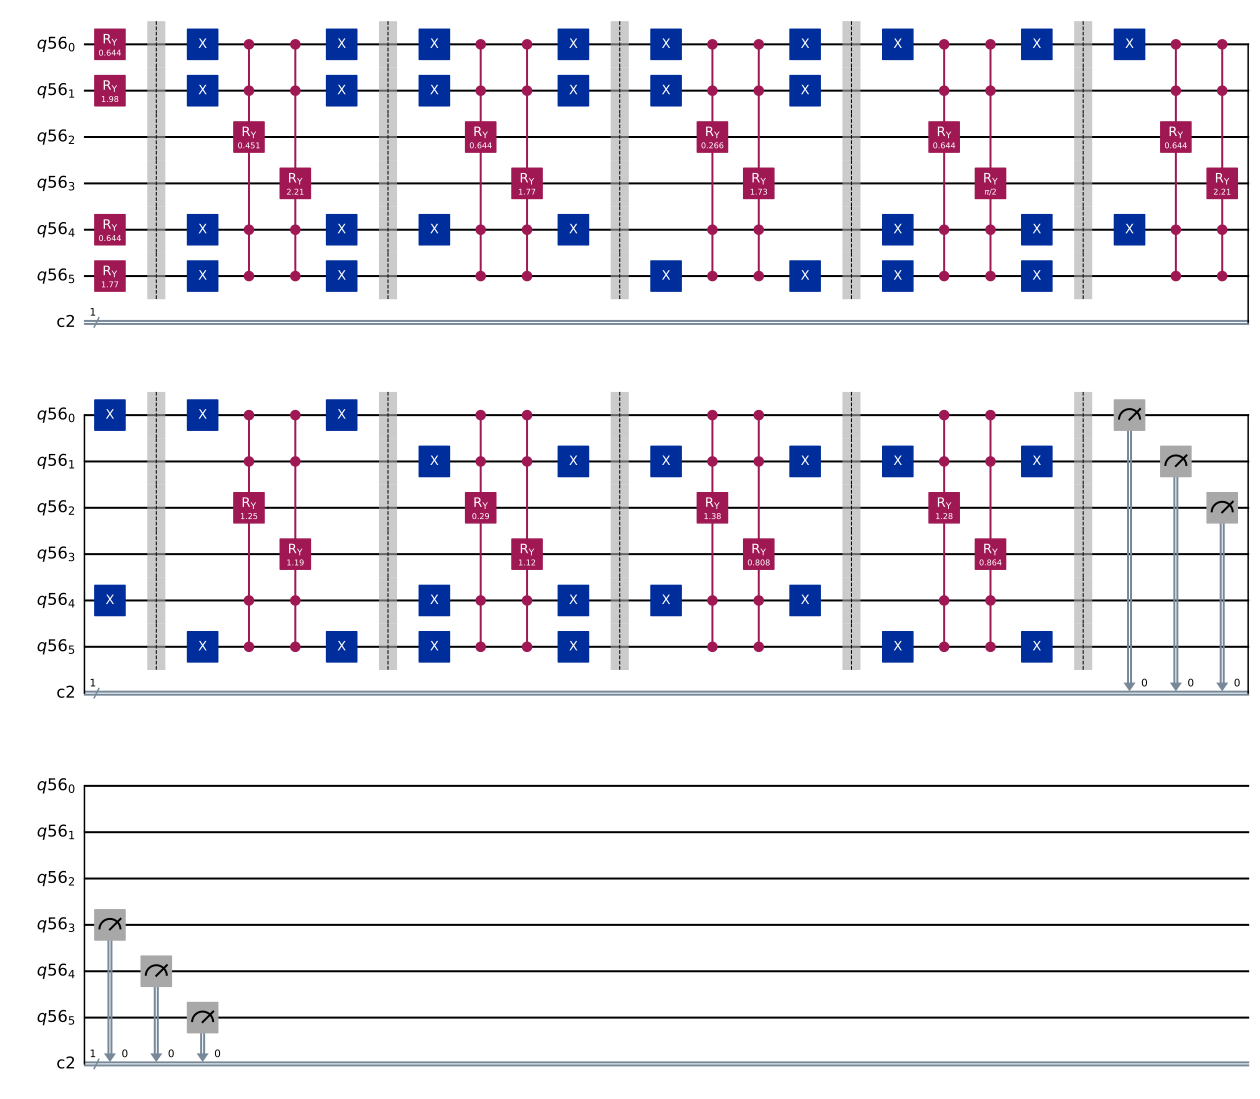

In [32]:
qbn = buildCircuit(bn)
qbn.draw(output="mpl")